In [1]:
import torch 
import pandas as pd
import collections
import numpy as np
import string

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class vocabulary(object):

    def __init__(self, token_to_idx = None, add_unk = True, unk_token = '<UNK>'):
        
        # Creating the dictionary that will contain the mapping from words to integers
        if token_to_idx is None:
            token_to_index = {}
            
        self._token_to_idx = token_to_index
        
        # We also create a local dictionary for mapping from integers to tokens/words
        self._idx_to_token = {idx : token
                             for token, idx in self._token_to_idx.items()}
        
        # Defining more local variables
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
        
        
        
    # THIS FUNCTION ALLOWS US TO ADD NEW TOKENS TO OUR DICTIONARY, returns the index of a token in the dictionary if
    # it exists, if it does not, then the token and index are created in both dictionaries
    def add_token(self,token):
            
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
            
        return index
    
    # THIS FUNCTION WILL GIVE US THE INDEX ASSOCIATED TO A GIVEN TOKEN
    # In this funtion, the method get returns the index given the token, if it does not find it then returns whatever it is
    # in the second argument, in this case, the index of the unknown terms
    def lookup_token(self,token):
        if self._add_unk:
            return self._token_to_idx.get(token,self.unk_index)
        else:
            return self._token_to_idx[token]
    
    # THIS FUNCTION WILL GIVE US THE TOKEN ASSOCIATED TO A GIVEN INDEX
    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError('the index (%d) is not in the vocabulary' %index)
        return self._idx_to_token[index]
    
    # IT BRINGS UP SOME SORT OF RESUME OF THE VOCABULARY OBJECT
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx,
               'add_unk': self._add_unk,
               'unk_token': self._unk_token}
    
    
    
    
    # PENDING TO DEFINE THE REAL FUNTION OF THIS CLASSMETHOD, WAIT FOR THE BIGGER PICTURE TO DEFINE IT

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
# For initializating this class, first we need the data and the target in the form torch.Tensor and we will also need
# the number of batchs that we want per epoch, we choose this parameter because it makes easier then for coding it

class data_loader_luis():
    def __init__(self,data,targets, n_batch):
        self.num_samples, self.n_features = data.shape
        self.data = data 
        self.targets = targets
        self.index = np.arange(self.num_samples)
        self.marker = 0 # this variable is going to take care that we are going through all the samples in each epoch
        self.n_batch = n_batch
        self.batch_size = round(self.num_samples / self.n_batch)
    
    def batch(self):
        # After one round, we are going to try to shuffle the samples so they are not deliver in the same order that 
        # the previous epoch
        
        if self.marker == self.num_samples:
            self.marker = 0
            np.random.shuffle(self.index)
       
        if self.marker + self.batch_size <= self.num_samples:
        
            index_chosen_batch = self.index[self.marker:(self.marker + self.batch_size)]
            self.marker = self.marker + self.batch_size
            data_batch_return = self.data[index_chosen_batch,:]
            targets_batch_return = self.targets[index_chosen_batch]
            
            return data_batch_return, targets_batch_return
        
        elif self.marker + self.batch_size > self.num_samples:
            
            leftovers_samples = self.num_samples - self.marker
            
            index_chosen_batch = self.index[self.marker:(self.marker + leftovers_samples)]
            self.marker = self.marker + leftovers_samples
            data_batch_return = self.data[index_chosen_batch,:]
            targets_batch_return = self.targets[index_chosen_batch]
            
            return data_batch_return, targets_batch_return

#### We're first going to create a vocabulary with the words in the train dataset, we are not using words from validation and test dataset because they are supposed to be unkown and we also want to test how good our model is doing without having any information about possible datasets that we have to evaluate

In [4]:
class dataset_processing():
    
    def __init__(self,reviews,ratings,review_vocab,rating_vocab,number_words,validation,test):

        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab
        self.number_words = number_words
        
        # train
        self.reviews = reviews
        self.ratings = ratings
        
        # validation
        self.validation_reviews = validation.review
        self.validation_rating = validation.rating
        
        # test
        self.test_reviews = test.review
        self.test_rating = test.rating
        
        # train, validation and test datasets encoded
        self.train_encoded = None
        self.validation_encoded = None
        self.test_encoded = None
    
    @classmethod
    def create_vocabulary(cls,train,validation,test,cutoff):
        reviews = train.review
        ratings = train.rating
        review_vocab = vocabulary(add_unk = True)
        rating_vocab = vocabulary(add_unk = False)
        
        word_count = collections.Counter()
        for review in reviews:
            for word in review.split(' '):
                word_count[word] += 1
                
        for word, count in word_count.items():
            if count>cutoff:
                review_vocab.add_token(word)
        
        
        for rating in sorted(set(ratings)):
            rating_vocab.add_token(rating)
           
        number_words = len(review_vocab)
         
        return cls(reviews,ratings,review_vocab,rating_vocab,number_words,validation,test)
        
        
    def vectorize(self,review):
        one_hot = np.zeros(self.number_words)
        for token in review.split(' '):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1
        
        return one_hot
        
        
    def transform_data_one_hot_encoded(self,dataset):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        encoded_dataset = torch.zeros(0,self.number_words,dtype=torch.float64).to(device)

        for review in dataset:
            encoded_sample = torch.tensor(self.vectorize(review),dtype=torch.float64).reshape(1,-1).to(device)
            encoded_dataset = torch.cat((encoded_dataset, encoded_sample), dim=0).to(device)
      
        return encoded_dataset.to(torch.device('cpu'))
        
    def transform_encoded_dataset(self):
        
        self.train_encoded = self.transform_data_one_hot_encoded(self.reviews)
        self.validation_encoded = self.transform_data_one_hot_encoded(self.validation_reviews)
        self.test_encoded = self.transform_data_one_hot_encoded(self.test_reviews)
    
    def __len__(self):
        return len(self.review_vocab)

##### Loading the datasets and transform them into the arrays for feeding them into the neural networks

In [5]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

In [6]:
dataset = dataset_processing.create_vocabulary(train,validation,test,25)

In [7]:
dataset.transform_encoded_dataset()

In [8]:
len(dataset)

2562

##### Model

In [9]:
class MLP(nn.Module):
    def __init__(self,num_features):
        
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features = num_features, out_features = 1)
        
    def forward(self, x_in, apply_sigmoid=False):
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = F.sigmoid(y_out)
        return y_out

In [10]:
model= MLP(len(dataset))

In [11]:
model

MLP(
  (fc1): Linear(in_features=2562, out_features=1, bias=True)
)

##### Loss, optimizer and dataloader

In [12]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params = model.parameters(), lr = 0.1)
n_batch = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We create the datalader with the encoded train dataset and the ratings of the training dataset
loader = data_loader_luis(dataset.train_encoded,torch.tensor(dataset.ratings.values),n_batch)

##### Training Loop

In [13]:
n_epochs = 200
error = []
error_validation = []


for epoch_i in range(n_epochs):
    for batch_i in range(n_batch):
    
        # Step 0: Generate the data for training
        x_data, targets = loader.batch()
        
        
        # Step 1: set up all the gradients in the model to zero, in order to avoid the accumulation of  
        # the gradients in each iteration
        model.zero_grad()
        
        
        # Step 2: compute the forward pass of the model
        y_pred = model(x_data.float().squeeze()).to(device)
        y_pred_validation = model(dataset.validation_encoded.float()).to(device)
        
        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_function(y_pred,targets.float().to(device))
        loss_validation = loss_function(y_pred_validation,torch.Tensor(dataset.validation_rating).to(device))
        error.append(loss.to(torch.device('cpu')))
        error_validation.append(loss_validation.to(torch.device('cpu')))
        
        
        # Step 4: Propagate the loss signal backwards
        loss.backward()
        
        
        # Step 5: Trigger the optimizer to perfomr the update
        optimizer.step()
    

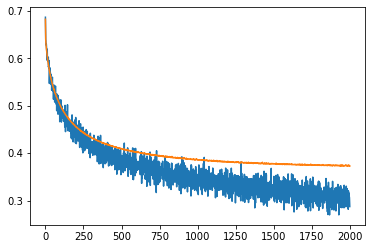

In [14]:
plt.plot(error)
plt.plot(error_validation)

In [15]:
y_pred_validation = model(dataset.validation_encoded.float())

In [16]:
def classifier(y_pred):
    y_pred_class = []
    for output in y_pred:
        if output > 0.5:
            y_pred_class.append(1)
        else:
            y_pred_class.append(0)
    return y_pred_class

In [17]:
def accuracy(y_pred,true_target):
    
    y_pred_class = classifier(y_pred)
    true_target = list(true_target)
    count = 0
    for i in range(len(y_pred_class)):
        if y_pred_class[i]==true_target[i]:
            count += 1
        else:
            pass
    return count/len(y_pred_class)

In [18]:
accuracy(y_pred_validation,dataset.validation_rating)

0.826

In [19]:
y_pred_test = model(dataset.test_encoded.float())

In [ ]:
accuracy(y_pred_test,dataset.test_rating)